<a href="https://colab.research.google.com/github/VictoorV/Transformer_Pre_In/blob/main/Transformer_Attention.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transformer

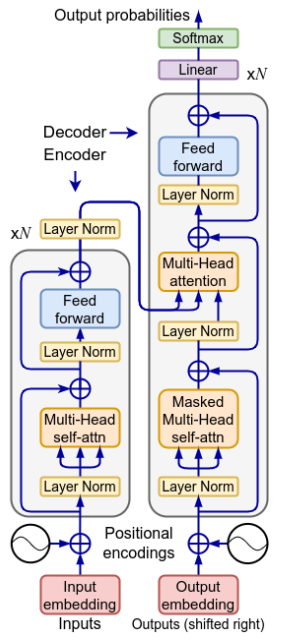

## Model

In [124]:
import copy
import numpy as np
import math
import torch

######################################################################################################## Avoir plusieurs modudes avec des références différentes
def clones(module, n):
    return torch.nn.ModuleList([copy.deepcopy(module) for _ in range(n)])

######################################################################################################## Scaled Dot Product Attention
def ScaledDotProductAttention(Q, K, V, mask = None):
  """
  Q : Query head ; shape : batch x n_head x n_token x d_head
  K : Key head ; shape : batch x n_head x n_token x d_head
  V : Value head ; shape : batch x n_head x n_token x d_head
  """

  d_head = Q.size(-1)
  scores = torch.matmul(Q, K.transpose(-2,-1)) / math.sqrt(d_head) # shape : batch * n_head * n_token * n_token
  if mask is not None:
    scores = scores.masked_fill_(mask==0, -1e9)

  weights = scores.softmax(-1)
  return torch.matmul(weights, V), weights

######################################################################################################## Multi-Head Attention
class Multi_Head_Attention(torch.nn.Module):
  def __init__(self, n_head, d_model, dropout=0.1):
    super(Multi_Head_Attention, self).__init__()
    assert d_model % n_head == 0
    self.n_head = n_head
    self.d_head = d_model // n_head
    self.layers = clones(torch.nn.Linear(d_model, d_model), 4)
    self.weights = None
    self.dropout = torch.nn.Dropout(dropout)

  def forward(self, Q, K, V, mask=None):
    """
    Q : Query embedding ; shape : batch x n_token x d_model
    K : Key embedding ; shape : batch x n_token x d_model
    V : Value embedding ; shape : batch x n_token x d_model
    """
    if mask is not None:
      mask = mask.unsqueeze(1)

    batch_size = Q.size(0)
    Q, K, V = [l(x).view(batch_size, -1, self.n_head, self.d_head).transpose(1,2) for l, x in zip(self.layers, (Q, K, V))] # batch x n_head x n_token x d_head
    x, self.weights = ScaledDotProductAttention(Q, K, V, mask=mask) # batch x n_head x n_token x d_head
    x = x.transpose(1,2).contiguous().view(batch_size, -1, self.n_head * self.d_head) # batch x n_token x d_model
    return self.layers[-1](self.dropout(x))

######################################################################################################## Double FFN
class FFN(torch.nn.Module):
  def __init__(self, d_model, d_ffn, dropout=0.1):
    super(FFN, self).__init__()
    self.layer1 = torch.nn.Linear(d_model, d_ffn)
    self.layer2 = torch.nn.Linear(d_ffn, d_model)
    self.dropout = torch.nn.Dropout(dropout)

  def forward(self, x):
    return self.layer2(self.dropout(torch.nn.functional.silu(self.layer1(x))))

######################################################################################################## Addition et normalisation pre-in
class PreNormResidual(torch.nn.Module):
  def __init__(self, d_model, dropout=0.1):
    super(PreNormResidual, self).__init__()
    self.norm = torch.nn.LayerNorm(d_model)
    self.dropout = torch.nn.Dropout(dropout)

  def forward(self, x, sublayer):
    return x + self.dropout(sublayer(self.norm(x)))

######################################################################################################## Encoder block
class EncoderBlock(torch.nn.Module):
  def __init__(self, n_head, d_model, d_ffn):
    super(EncoderBlock, self).__init__()
    self.MHA = Multi_Head_Attention(n_head, d_model)
    self.Norm_And_Add = clones(PreNormResidual(d_model), 2)
    self.FFN = FFN(d_model, d_ffn)

  def forward(self, x, source_mask):
    """
    x : Input ; shape : batch x n_token x d_model
    source_mask : Mask of source sentence (padding tokens are masked) ; shape : batch x n_token x n_token
    """
    x = self.Norm_And_Add[0](x, lambda x: self.MHA(x, x, x, mask=source_mask))
    return self.Norm_And_Add[1](x, self.FFN)

######################################################################################################## Encoder
class Encoder(torch.nn.Module):
  def __init__(self, n_head, d_model, d_ffn, N):
    super(Encoder, self).__init__()
    self.layers = clones(EncoderBlock(n_head, d_model, d_ffn), N)
    self.norm = torch.nn.LayerNorm(d_model)

  def forward(self, x, source_mask):
    for layer in self.layers:
      x = layer(x, source_mask)
    return self.norm(x)

######################################################################################################## Decoder block
class DecoderBlock(torch.nn.Module):
  def __init__(self, n_head, d_model, d_ffn):
    super(DecoderBlock, self).__init__()
    self.MHA_Masked = Multi_Head_Attention(n_head, d_model)
    self.MHA_Encoder = Multi_Head_Attention(n_head, d_model)
    self.Norm_And_Add = clones(PreNormResidual(d_model), 3)
    self.FFN = FFN(d_model, d_ffn)

  def forward(self, x, encoder_output, source_mask, target_mask):
    """
    x : Output ; shape : batch x n_token x d_model
    encoder_output : Encoder final states ; shape : batch x n_token x d_model
    source_mask : Mask of source sentence (padding tokens are masked) ; shape : batch x n_token x n_token
    target_mask : Mask of target sentence (future and padding tokens are masked) ; shape : batch x n_token x n_token
    """
    x = self.Norm_And_Add[0](x, lambda x: self.MHA_Masked(x, x, x, mask=target_mask))
    x = self.Norm_And_Add[1](x, lambda x: self.MHA_Encoder(x, encoder_output, encoder_output, mask=source_mask))
    return self.Norm_And_Add[2](x, self.FFN)

######################################################################################################## Decoder
class Decoder(torch.nn.Module):
  def __init__(self, target_vocab_size, n_head, d_model, d_ffn, N):
    super(Decoder, self).__init__()
    self.layers = clones(DecoderBlock(n_head, d_model, d_ffn), N)
    self.norm = torch.nn.LayerNorm(d_model)
    self.final_layer = torch.nn.Linear(d_model, target_vocab_size)

  def forward(self, x, encoder_output, source_mask, target_mask):
    for layer in self.layers:
      x = layer(x, encoder_output, source_mask, target_mask)
    x = self.norm(x)
    return torch.nn.functional.log_softmax(self.final_layer(x), dim=-1)

######################################################################################################## Encoder + Decoder
class EncoderDecoder(torch.nn.Module):
  def __init__(self, target_vocab_size, n_head, d_model, d_ffn, N):
    super(EncoderDecoder, self).__init__()
    self.encoder = Encoder(n_head, d_model, d_ffn, N)
    self.decoder = Decoder(target_vocab_size, n_head, d_model, d_ffn, N)
    self.norm = torch.nn.LayerNorm(d_model)

  def forward(self, source, target, source_mask, target_mask):
    encoder_output = self.norm(self.encoder(source, source_mask))
    return self.decoder(target, encoder_output, source_mask, target_mask)

######################################################################################################## Embedding
class Embeddings(torch.nn.Module):
  def __init__(self, voc_size, d_model):
    super(Embeddings, self).__init__()
    self.embedding = torch.nn.Embedding(voc_size, d_model)
    self.d_model = d_model

  def forward(self, x):
    """
    x : Input (int) ; shape : batch * n_token
    """
    return self.embedding(x) * math.sqrt(self.d_model)

######################################################################################################## Positional encoding
class PositionalEncoding(torch.nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = torch.nn.Dropout(p=dropout)

        # Compute the positional encodings once in log space.
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) *
                             -(math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:, :x.size(1)]
        return self.dropout(x)

######################################################################################################## Build Transformer
class Transformer(torch.nn.Module):
  def __init__(self, source_vocab_size, target_vocab_size, n_head, d_model, d_ffn, N):
    super(Transformer, self).__init__()
    self.source_embedding = Embeddings(source_vocab_size, d_model)
    self.target_embedding = Embeddings(target_vocab_size, d_model)
    self.PE = PositionalEncoding(d_model)
    self.encoder_decoder = EncoderDecoder(target_vocab_size, n_head, d_model, d_ffn, N)
    for p in self.parameters():
            if p.dim() > 1:
                torch.nn.init.xavier_uniform_(p)

  def forward(self, source, target, source_mask, target_mask):
    """
    source : Input (int) ; shape : batch * n_token
    target : Output (int) ; shape : batch * n_token
    """
    source = self.PE(self.source_embedding(source))
    target = self.PE(self.target_embedding(target))
    output = self.encoder_decoder(source, target, source_mask, target_mask)
    return output

In [122]:
model = Transformer(11,11,8,512,2048,2)

In [38]:
for name1, param1 in model.named_parameters():
    for name2, param2 in model.named_parameters():
        if name1 != name2 and param1.data_ptr() == param2.data_ptr():
            print(f"{name1} et {name2} partagent le même stockage !")

In [38]:
for name1, param1 in model.named_parameters():
    for name2, param2 in model.named_parameters():
        if name1 != name2 and torch.equal(param1, param2):
            print(f"{name1} et {name2} ont les mêmes valeurs !")

In [36]:
for name1, param1 in model.named_parameters():
    for name2, param2 in model.named_parameters():
        if name1 != name2 and param1 is param2:
            print(f"{name1} et {name2} sont la même instance !")

In [123]:
L = []
for name1, param1 in model.named_parameters():
  L.append(param1)
print(len(L))

92


In [119]:
len(list(model.parameters()))

94

In [69]:
len(list(model.parameters()))

92

In [38]:
for name, param in model.named_parameters():
    print(name, param.shape, param)

In [48]:
input_seq = [
    ["salut", "comment", "ca", "va", "?"],
    ["je", "veux", "beaucoup", "de", "fruits", "rouges", "."],
    ["j'", "aimerais", "manger", "des", "fruits", "."],
    ["regarde", "ces", "petits", "oiseaux", "faire", "du", "vent", "."]
             ]

output_seq = [
    ["[START]", "hi", "how", "are", "you", "?", "[END]"],
    ["[START]", "i", "want", "a", "lot", "of", "red", "fruits", ".", "[END]"],
    ["[START]", "i", "would", "like", "to", "eat", "fruits", ".", "[END]"],
    ["[START]", "look", "at", "these", "little", "birds", "blowing", "the", "wind", ".", "[END]"]
]

def get_vocabulary(sequences):
  vocabulary = {}
  vocabulary["[PAD]"] = 0; vocabulary["[UNK]"] = 1; vocabulary["[START]"] = 2; vocabulary["[END]"] = 3
  for sequence in sequences:
    for token in sequence:
      if token not in vocabulary:
        vocabulary[token] = len(vocabulary)
  return vocabulary

input_voc = get_vocabulary(input_seq)
output_voc = get_vocabulary(output_seq)

print(input_voc)
print(output_voc)

def seq_to_int(sequences, voc, max_length=None):
  sequences_copy = copy.deepcopy(sequences)
  for sequence in sequences_copy:
    if max_length is not None:
      while len(sequence) < max_length:
        sequence.append("[PAD]")
    for i, word in enumerate(sequence):
      if word in voc:
        sequence[i] = voc[word]
      else:
        sequence[i] = voc["[UNK]"]
  return(sequences_copy)

max_input_len = max(len(seq) for seq in input_seq)
max_output_len = max(len(seq) for seq in output_seq)

input_to_int = seq_to_int(input_seq, input_voc, max_input_len)
output_to_int = seq_to_int(output_seq, output_voc, max_output_len)

tensor_input_to_int = torch.tensor(input_to_int).int()
tensor_output_to_int = torch.tensor(output_to_int).int()

print("source tenseur padded:\n", tensor_input_to_int)
print("target tenseur padded:\n,", tensor_output_to_int)

def create_source_mask(source_tensor, voc):
  mask = source_tensor != voc["[PAD]"]
  mask = mask.unsqueeze(1) * torch.ones(source_tensor.size(-1)).unsqueeze(1)
  return mask.bool()

source_mask = create_source_mask(tensor_input_to_int, input_voc)
print("source_mask:\n", source_mask)

def create_target_mask(target_tensor, voc):
  mask = target_tensor != voc["[PAD]"]
  mask = mask.unsqueeze(1) * torch.ones(target_tensor.size(-1)).unsqueeze(1)
  mask = mask * torch.tril(torch.ones(mask.size(1), mask.size(1))).unsqueeze(0)
  return mask.bool()

target_mask = create_target_mask(tensor_output_to_int, output_voc)
print("target_mask:\n", target_mask)

{'[PAD]': 0, '[UNK]': 1, '[START]': 2, '[END]': 3, 'salut': 4, 'comment': 5, 'ca': 6, 'va': 7, '?': 8, 'je': 9, 'veux': 10, 'beaucoup': 11, 'de': 12, 'fruits': 13, 'rouges': 14, '.': 15, "j'": 16, 'aimerais': 17, 'manger': 18, 'des': 19, 'regarde': 20, 'ces': 21, 'petits': 22, 'oiseaux': 23, 'faire': 24, 'du': 25, 'vent': 26}
{'[PAD]': 0, '[UNK]': 1, '[START]': 2, '[END]': 3, 'hi': 4, 'how': 5, 'are': 6, 'you': 7, '?': 8, 'i': 9, 'want': 10, 'a': 11, 'lot': 12, 'of': 13, 'red': 14, 'fruits': 15, '.': 16, 'would': 17, 'like': 18, 'to': 19, 'eat': 20, 'look': 21, 'at': 22, 'these': 23, 'little': 24, 'birds': 25, 'blowing': 26, 'the': 27, 'wind': 28}
source tenseur padded:
 tensor([[ 4,  5,  6,  7,  8,  0,  0,  0],
        [ 9, 10, 11, 12, 13, 14, 15,  0],
        [16, 17, 18, 19, 13, 15,  0,  0],
        [20, 21, 22, 23, 24, 25, 26, 15]], dtype=torch.int32)
target tenseur padded:
, tensor([[ 2,  4,  5,  6,  7,  8,  3,  0,  0,  0,  0],
        [ 2,  9, 10, 11, 12, 13, 14, 15, 16,  3,  0],

In [50]:
n_head = 8
d_model = 512
d_ffn = 2048
N = 2
model = Transformer(len(input_voc), len(output_voc), n_head, d_model, d_ffn, N)

In [8]:
len(list(model.parameters()))

258

In [20]:
model(tensor_input_to_int, tensor_output_to_int, source_mask, target_mask)

tensor([[[1.8699e-03, 2.5772e-02, 6.3248e-06,  ..., 1.3034e-05,
          7.0763e-05, 8.5320e-06],
         [9.0335e-03, 9.7057e-01, 6.0350e-05,  ..., 1.6172e-05,
          2.6115e-04, 5.7880e-09],
         [1.7247e-01, 8.3588e-03, 5.4504e-04,  ..., 1.9153e-02,
          4.8970e-05, 9.8968e-09],
         ...,
         [4.9266e-03, 1.5311e-04, 9.4524e-05,  ..., 3.2203e-06,
          1.7152e-05, 7.1395e-07],
         [2.6186e-06, 8.2919e-06, 3.9559e-03,  ..., 1.0159e-06,
          8.7106e-08, 4.8408e-07],
         [3.7756e-04, 2.8147e-04, 1.4875e-04,  ..., 2.9239e-04,
          1.3087e-06, 3.7688e-06]],

        [[6.1024e-08, 4.0279e-08, 1.1289e-07,  ..., 1.2900e-08,
          3.9993e-08, 2.1249e-10],
         [9.3655e-06, 1.5897e-09, 4.6000e-07,  ..., 3.2081e-07,
          6.6326e-11, 1.1349e-08],
         [2.8567e-03, 3.9030e-09, 4.1999e-06,  ..., 4.2084e-06,
          8.9316e-09, 4.1182e-06],
         ...,
         [6.5728e-03, 5.3928e-05, 4.9755e-06,  ..., 1.0507e-06,
          2.264

In [5]:
model

Transformer(
  (source_embedding): Embeddings(
    (embedding): Embedding(27, 512)
  )
  (target_embedding): Embeddings(
    (embedding): Embedding(29, 512)
  )
  (PE): PositionalEncoding()
  (encoder_decoder): EncoderDecoder(
    (encoder): Encoder(
      (layers): ModuleList(
        (0-5): 6 x EncoderBlock(
          (MHA): Multi_Head_Attention(
            (layers): ModuleList(
              (0-3): 4 x Linear(in_features=512, out_features=512, bias=True)
            )
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (Norm_And_Add): ModuleList(
            (0-1): 2 x PreNormResidual(
              (norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
          )
          (FFN): FFN(
            (layer1): Linear(in_features=512, out_features=2048, bias=True)
            (layer2): Linear(in_features=2048, out_features=512, bias=True)
            (dropout): Dropout(p=0.1, inplace=Fal

## Data

In [6]:
import pandas as pd

df = pd.read_csv("hf://datasets/FrancophonIA/english_french/train.csv")
df.head()

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


,english,french
0,she was driving the shiny black car.,elle conduisait la voiture noire brillante.
1,"china is never quiet during autumn, but it is ...","chine est jamais calme à l'automne, mais il es..."
2,Aren't you surprised to see me here?,N'es-tu pas surprise de me voir ici ?
3,She divorced her husband.,Elle divorça de son mari.
4,"paris is sometimes freezing during june, but i...","paris est parfois le gel en juin, mais il est ..."


In [7]:
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained("bert-base-multilingual-cased")

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

In [8]:
from torch.utils.data import Dataset

class TranslationDataset(Dataset):
    def __init__(self, dataframe, src_lang='english', tgt_lang='french', max_len=100):
        self.data = dataframe
        self.src_lang = src_lang
        self.tgt_lang = tgt_lang
        self.max_len = max_len

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        src_text = str(self.data.iloc[idx][self.src_lang])
        tgt_text = str(self.data.iloc[idx][self.tgt_lang])

        src_encoding = tokenizer(src_text, truncation=True, max_length=self.max_len, return_tensors='pt')
        tgt_encoding = tokenizer(tgt_text, truncation=True, max_length=self.max_len, return_tensors='pt')

        src_tensor = src_encoding['input_ids'].squeeze(0)
        tgt_tensor = tgt_encoding['input_ids'].squeeze(0)

        return src_tensor, tgt_tensor, _, _

dataset = TranslationDataset(df)

In [9]:
def create_source_mask(source_tensor, voc):
  mask = source_tensor != voc["[PAD]"]
  mask = mask.unsqueeze(1) * torch.ones(source_tensor.size(-1)).unsqueeze(1)
  return mask.bool()

def create_target_mask(target_tensor, voc):
  mask = target_tensor != voc["[PAD]"]
  mask = mask.unsqueeze(1) * torch.ones(target_tensor.size(-1)).unsqueeze(1)
  mask = mask * torch.tril(torch.ones(mask.size(1), mask.size(1))).unsqueeze(0)
  return mask.bool()

In [10]:
from torch.utils.data import DataLoader

def collate_fn(batch):
  src_batch, tgt_batch, src_mask_batch, tgt_mask_batch = zip(*batch)
  src_batch = torch.nn.utils.rnn.pad_sequence(src_batch, batch_first=True)
  tgt_batch = torch.nn.utils.rnn.pad_sequence(tgt_batch, batch_first=True)
  return src_batch, tgt_batch, create_source_mask(src_batch, tokenizer.vocab), create_target_mask(tgt_batch, tokenizer.vocab)

dataloader = DataLoader(dataset, batch_size=32, shuffle=True, collate_fn=collate_fn)

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Transformer(11, 11, 8, 512, 2048, 6)
model.to(device)

Transformer(
  (source_embedding): Embeddings(
    (embedding): Embedding(11, 512)
  )
  (target_embedding): Embeddings(
    (embedding): Embedding(11, 512)
  )
  (PE): PositionalEncoding()
  (encoder_decoder): EncoderDecoder(
    (encoder): Encoder(
      (layers): ModuleList(
        (0-5): 6 x EncoderBlock(
          (MHA): Multi_Head_Attention(
            (layers): ModuleList(
              (0-3): 4 x Linear(in_features=512, out_features=512, bias=True)
            )
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (Norm_And_Add): ModuleList(
            (0-1): 2 x PreNormResidual(
              (norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
          )
          (FFN): FFN(
            (layer1): Linear(in_features=512, out_features=2048, bias=True)
            (layer2): Linear(in_features=2048, out_features=512, bias=True)
            (dropout): Dropout(p=0.1, inplace=Fal

In [8]:
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

In [21]:
def train_model(model, loss_function, optimizer, data_loader):
    model.train()

    current_loss = 0.0
    counter = 0

    # iterate over the training data
    for i, (src_batch, tgt_batch, src_mask, tgt_mask) in enumerate(data_loader):
      src_batch = src_batch.to(device)
      tgt_batch = tgt_batch.to(device)
      src_mask = src_mask.to(device)
      tgt_mask = tgt_mask.to(device)

      optimizer.zero_grad()

      out = model(src_batch, tgt_batch, src_mask, tgt_mask)

      loss = loss_function(out.view(-1, out.size(-1)), tgt_batch.contiguous().view(-1))

      loss.backward()

      optimizer.step()

      current_loss += loss
      counter += 1

      if counter % 5 == 0:
        print("Batch: %d; Loss: %f" % (i + 1, current_loss / counter))
        current_loss = 0.0
        counter = 0

In [18]:
train_model(model, loss_function, optimizer, dataloader)

In [75]:
864/32

27.0

In [9]:
class RandomDataset(torch.utils.data.Dataset):
    """Random data copy dataset"""

    def __init__(self, V, total_samples, sample_length):
        self.samples = list()

        sample = dict()
        for i in range(total_samples):
            data = torch.from_numpy(np.random.randint(1, V, size=(sample_length,)))
            data[0] = 1
            source = torch.autograd.Variable(data, requires_grad=False)
            target = torch.autograd.Variable(data, requires_grad=False)

            sample['source'] = source
            sample['target'] = target[:-1]
            sample['target_y'] = target[1:]
            sample['source_mask'] = (source != 0).unsqueeze(-2)
            sample['target_mask'] = self.make_std_mask(sample['target'], 0)
            sample['tokens_count'] = (sample['target_y'] != 0).data.sum()

            self.samples.append(sample)

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        return self.samples[idx]

    @staticmethod
    def make_std_mask(target, pad):
        """Create a mask to hide padding and future words."""
        target_mask = (target != pad)
        target_mask = target_mask & torch.autograd.Variable(
            RandomDataset.subsequent_mask(target.size(-1)).type_as(target_mask.data))

        return target_mask

    @staticmethod
    def subsequent_mask(size):
        """Mask out subsequent positions."""
        attn_shape = (size, size)
        subsequent_mask = np.triu(np.ones(attn_shape), k=1).astype('uint8')
        return torch.from_numpy(subsequent_mask) == 0


def train_model(model, loss_function, optimizer, data_loader):
    # set model to training mode
    model.train()

    current_loss = 0.0
    counter = 0

    # iterate over the training data
    for i, batch in enumerate(data_loader):
        with torch.set_grad_enabled(True):
            out = model(batch['source'].to(device), batch['target'].to(device),
                                batch['source_mask'].to(device), batch['target_mask'].to(device))

            loss = loss_function(out.contiguous().view(-1, out.size(-1)),
                                 batch['target_y'].to(device).contiguous().view(-1))

            loss.backward()

            optimizer.step()
            optimizer.zero_grad()

            # statistics
            current_loss += loss
            counter += 1

            if counter % 5 == 0:
                print("Batch: %d; Loss: %f" % (i + 1, current_loss / counter))
                current_loss = 0.0
                counter = 0

In [95]:
BATCH_SIZE = 50
train_set = RandomDataset(11, BATCH_SIZE * 100, 10)

train_loader = torch.utils.data.DataLoader(train_set,
                                            batch_size=BATCH_SIZE)
model = Transformer(11, 11, 8, 512, 2048, N=2)

train_model(model, loss_function, optimizer, train_loader)

Batch: 5; Loss: 3.759146
Batch: 10; Loss: 3.784307
Batch: 15; Loss: 3.790561
Batch: 20; Loss: 3.791143


KeyboardInterrupt: 

In [101]:
"""
MIT License

This example is based on https://github.com/harvardnlp/annotated-transformer
Copyright (c) 2018 Alexander Rush
Copyright (c) 2019 Ivan Vasilev

Permission is hereby granted, free of charge, to any person obtaining a copy
of this software and associated documentation files (the "Software"), to deal
in the Software without restriction, including without limitation the rights
to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
copies of the Software, and to permit persons to whom the Software is
furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all
copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
SOFTWARE.
"""

import copy
import math

import numpy as np
import torch


def attention(query, key, value, mask=None, dropout=None):
    """Scaled Dot Product Attention"""
    d_k = query.size(-1)

    # 1) and 2) Compute the alignment scores with scaling
    scores = (query @ key.transpose(-2, -1)) \
             / math.sqrt(d_k)
    if mask is not None:
        scores = scores.masked_fill(mask == 0, -1e9)

    # 3) Compute the attention scores (softmax)
    p_attn = scores.softmax(dim=-1)

    if dropout is not None:
        p_attn = dropout(p_attn)

    # 4) Apply the attention scores over the values
    return p_attn @ value, p_attn


class MultiHeadedAttention(torch.nn.Module):
    def __init__(self, h, d_model, dropout=0.1):
        """
        :param h: number of heads
        :param d_model: query/key/value vector length
        """
        super(MultiHeadedAttention, self).__init__()
        assert d_model % h == 0
        # We assume d_v always equals d_k
        self.d_k = d_model // h
        self.h = h

        # Create 4 fully connected layers
        # 3 for the query/key/value projections
        # 1 to concatenate the outputs of all heads
        self.fc_layers = clones(
            torch.nn.Linear(d_model, d_model), 4)
        self.attn = None
        self.dropout = torch.nn.Dropout(p=dropout)

    def forward(self, query, key, value, mask=None):
        if mask is not None:
            # Same mask applied to all h heads.
            mask = mask.unsqueeze(1)

        batch_samples = query.size(0)

        # 1) Do all the linear projections in batch from d_model => h x d_k
        projections = [
            l(x).view(batch_samples, -1, self.h, self.d_k)
            .transpose(1, 2)
            for l, x in zip(self.fc_layers, (query, key, value))
        ]

        query, key, value = projections

        # 2) Apply attention on all the projected vectors in batch.
        x, self.attn = attention(
            query, key, value,
            mask=mask,
            dropout=self.dropout)

        # 3) "Concat" using a view and apply a final linear.
        x = x.transpose(1, 2).contiguous() \
            .view(batch_samples, -1, self.h * self.d_k)

        return self.fc_layers[-1](x)


def clones(module: torch.nn.Module, n: int):
    """
    Produce N identical copies of module in a ModuleList
    :param module: The module to be copied.
        The module itself is not part of the output module list
     :param n: Number of copies
    """
    return torch.nn.ModuleList([copy.deepcopy(module) for _ in range(n)])


class PositionwiseFFN(torch.nn.Module):
    """Implements FFN equation from the paper"""

    def __init__(self, d_model: int, d_ff: int, dropout=0.1):
        super(PositionwiseFFN, self).__init__()
        self.w_1 = torch.nn.Linear(d_model, d_ff)
        self.w_2 = torch.nn.Linear(d_ff, d_model)
        self.dropout = torch.nn.Dropout(dropout)

    def forward(self, x):
        return self.w_2(
            self.dropout(
                torch.nn.functional.silu(
                    self.w_1(x)
                )))


class Embeddings(torch.nn.Module):
    """Encoder/Decoder input embeddings"""

    def __init__(self, d_model, vocab_size):
        super(Embeddings, self).__init__()
        self.lut = torch.nn.Embedding(vocab_size, d_model)
        self.d_model = d_model

    def forward(self, x):
        return self.lut(x) * math.sqrt(self.d_model)


class SublayerConnection(torch.nn.Module):
    """
    A residual connection followed by a layer norm.
    Note for code simplicity the norm is first as opposed to last.
    """

    def __init__(self, size, dropout):
        super(SublayerConnection, self).__init__()
        self.norm = torch.nn.LayerNorm(size)
        self.dropout = torch.nn.Dropout(dropout)

    def forward(self, x, sublayer):
        """Apply residual connection to any sublayer with the same size."""
        return x + self.dropout(sublayer(self.norm(x)))


class PositionalEncoding(torch.nn.Module):
    def __init__(self, d_model, dropout, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = torch.nn.Dropout(p=dropout)

        # Compute the positional encodings once in log space.
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) *
                             -(math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:, :x.size(1)].requires_grad_(requires_grad=False)
        return self.dropout(x)


class EncoderBlock(torch.nn.Module):
    """Encoder block with self-attention and residual connections"""

    def __init__(self,
                 size: int,
                 self_attn: MultiHeadedAttention,
                 ffn: PositionwiseFFN,
                 dropout=0.1):
        super(EncoderBlock, self).__init__()
        self.self_attn = self_attn
        self.ffn = ffn

        # Create 2 sub-layer connections
        # 1 for the self-attention
        # 1 for the FFN
        self.sublayers = clones(SublayerConnection(size, dropout), 2)
        self.size = size

    def forward(self, x, mask):
        """Self-attention, followed by FFN + residual connections"""
        x = self.sublayers[0](x, lambda x: self.self_attn(x, x, x, mask))
        return self.sublayers[1](x, self.ffn)


class Encoder(torch.nn.Module):
    """Transformer encoder with a stack of N blocks"""

    def __init__(self, block: EncoderBlock, N: int):
        super(Encoder, self).__init__()
        self.blocks = clones(block, N)
        self.norm = torch.nn.LayerNorm(block.size)

    def forward(self, x, mask):
        """Iterate over all blocks and normalize"""
        for layer in self.blocks:
            x = layer(x, mask)

        return self.norm(x)


class DecoderBlock(torch.nn.Module):
    """One decoder block, composed of self-attention, encoder-attention, and FFN"""

    def __init__(self,
                 size: int,
                 self_attn: MultiHeadedAttention,
                 encoder_attn: MultiHeadedAttention,
                 ffn: PositionwiseFFN,
                 dropout=0.1):
        super(DecoderBlock, self).__init__()
        self.size = size
        self.self_attn = self_attn
        self.encoder_attn = encoder_attn
        self.ffn = ffn

        # Create 3 sub-layer connections
        # 1 for the self-attention
        # 1 for the encoder attention
        # 1 for the FFN
        self.sublayers = clones(SublayerConnection(size, dropout), 3)

    def forward(self, x, encoder_states, source_mask, target_mask):
        x = self.sublayers[0](x, lambda x: self.self_attn(x, x, x, target_mask))
        x = self.sublayers[1](x, lambda x: self.encoder_attn(x, encoder_states, encoder_states, source_mask))
        return self.sublayers[2](x, self.ffn)


class Decoder(torch.nn.Module):
    """Generic N layer decoder with masking."""

    def __init__(self, block: DecoderBlock, N: int, vocab_size: int):
        super(Decoder, self).__init__()
        self.blocks = clones(block, N)
        self.norm = torch.nn.LayerNorm(block.size)
        self.projection = torch.nn.Linear(block.size, vocab_size)

    def forward(self, x, encoder_states, source_mask, target_mask):
        for layer in self.blocks:
            x = layer(x, encoder_states, source_mask, target_mask)

        x = self.norm(x)

        return torch.nn.functional.log_softmax(self.projection(x), dim=-1)


class EncoderDecoder(torch.nn.Module):
    """A Encoder-Decoder architecture"""

    def __init__(self,
                 encoder: Encoder,
                 decoder: Decoder,
                 source_embeddings: torch.nn.Sequential,
                 target_embeddings: torch.nn.Sequential):
        super(EncoderDecoder, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.source_embeddings = source_embeddings
        self.target_embeddings = target_embeddings

    def forward(self, source, target, source_mask, target_mask):
        """Take in and process masked src and target sequences."""
        encoder_output = self.encoder(
            x=self.source_embeddings(source),
            mask=source_mask)

        return self.decoder(
            x=self.target_embeddings(target),
            encoder_states=encoder_output,
            source_mask=source_mask,
            target_mask=target_mask)


def build_model(source_vocabulary: int,
                target_vocabulary: int,
                N=6, d_model=512, d_ff=2048, h=8, dropout=0.1):
    """Build the full transformer model"""
    c = copy.deepcopy
    attn = MultiHeadedAttention(h, d_model)
    ff = PositionwiseFFN(d_model, d_ff, dropout)
    position = PositionalEncoding(d_model, dropout)

    model = EncoderDecoder(
        encoder=Encoder(
            EncoderBlock(d_model, c(attn), c(ff), dropout), N),
        decoder=Decoder(
            DecoderBlock(d_model, c(attn), c(attn),
                                     c(ff), dropout), N, target_vocabulary),
        source_embeddings=torch.nn.Sequential(
            Embeddings(d_model, source_vocabulary), c(position)),
        target_embeddings=torch.nn.Sequential(
            Embeddings(d_model, target_vocabulary), c(position)))

    # Initialize parameters with Glorot / fan_avg.
    for p in model.parameters():
        if p.dim() > 1:
            torch.nn.init.xavier_uniform_(p)

    return model


class RandomDataset(torch.utils.data.Dataset):
    """Random data copy dataset"""

    def __init__(self, V, total_samples, sample_length):
        self.samples = list()

        sample = dict()
        for i in range(total_samples):
            data = torch.from_numpy(np.random.randint(1, V, size=(sample_length,)))
            data[0] = 1
            source = torch.autograd.Variable(data, requires_grad=False)
            target = torch.autograd.Variable(data, requires_grad=False)

            sample['source'] = source
            sample['target'] = target[:-1]
            sample['target_y'] = target[1:]
            sample['source_mask'] = (source != 0).unsqueeze(-2)
            sample['target_mask'] = self.make_std_mask(sample['target'], 0)
            sample['tokens_count'] = (sample['target_y'] != 0).data.sum()

            self.samples.append(sample)

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        return self.samples[idx]

    @staticmethod
    def make_std_mask(target, pad):
        """Create a mask to hide padding and future words."""
        target_mask = (target != pad)
        target_mask = target_mask & torch.autograd.Variable(
            RandomDataset.subsequent_mask(target.size(-1)).type_as(target_mask.data))

        return target_mask

    @staticmethod
    def subsequent_mask(size):
        """Mask out subsequent positions."""
        attn_shape = (size, size)
        subsequent_mask = np.triu(np.ones(attn_shape), k=1).astype('uint8')
        return torch.from_numpy(subsequent_mask) == 0


def train_model(model, loss_function, optimizer, data_loader):
    # set model to training mode
    model.train()

    current_loss = 0.0
    counter = 0

    # iterate over the training data
    for i, batch in enumerate(data_loader):
        with torch.set_grad_enabled(True):
            out = model.forward(batch['source'], batch['target'],
                                batch['source_mask'], batch['target_mask'])

            loss = loss_function(out.contiguous().view(-1, out.size(-1)),
                                 batch['target_y'].contiguous().view(-1))

            loss.backward()

            optimizer.step()
            optimizer.zero_grad()

            # statistics
            current_loss += loss
            counter += 1

            if counter % 5 == 0:
                print("Batch: %d; Loss: %f" % (i + 1, current_loss / counter))
                current_loss = 0.0
                counter = 0


if __name__ == '__main__':
    V = 11
    BATCH_SIZE = 50
    train_set = RandomDataset(11, BATCH_SIZE * 1000, 10)

    train_loader = torch.utils.data.DataLoader(train_set,
                                               batch_size=BATCH_SIZE)

    model = build_model(V, V, N=2)
    #model = Transformer(11, 11, 8, 512, 2048, 2)
    optimizer = torch.optim.Adam(model.parameters())
    loss_function = torch.nn.CrossEntropyLoss()

    train_model(model, loss_function, optimizer, train_loader)

Batch: 5; Loss: 2.757261
Batch: 10; Loss: 0.863251
Batch: 15; Loss: 0.281179
Batch: 20; Loss: 0.226628
Batch: 25; Loss: 0.184146
Batch: 30; Loss: 0.171538
Batch: 35; Loss: 0.157910
Batch: 40; Loss: 0.153804
Batch: 45; Loss: 0.154775
Batch: 50; Loss: 0.151768
Batch: 55; Loss: 0.144459
Batch: 60; Loss: 0.146691
Batch: 65; Loss: 0.144712
Batch: 70; Loss: 0.139663
Batch: 75; Loss: 0.138060
Batch: 80; Loss: 0.131194
Batch: 85; Loss: 0.125702
Batch: 90; Loss: 0.115431
Batch: 95; Loss: 0.097231
Batch: 100; Loss: 0.067841
Batch: 105; Loss: 0.404229
Batch: 110; Loss: 0.312045
Batch: 115; Loss: 0.184247
Batch: 120; Loss: 0.151698
Batch: 125; Loss: 0.128784
Batch: 130; Loss: 0.111312
Batch: 135; Loss: 0.098097
Batch: 140; Loss: 0.082940
Batch: 145; Loss: 0.068174
Batch: 150; Loss: 0.050953
Batch: 155; Loss: 0.033943
Batch: 160; Loss: 0.019421
Batch: 165; Loss: 0.009920
Batch: 170; Loss: 0.003401
Batch: 175; Loss: 0.001787
Batch: 180; Loss: 0.000962
Batch: 185; Loss: 0.000661
Batch: 190; Loss: 0.0

KeyboardInterrupt: 

In [111]:
if __name__ == '__main__':
    V = 11
    BATCH_SIZE = 50
    train_set = RandomDataset(11, BATCH_SIZE * 1000, 10)

    train_loader = torch.utils.data.DataLoader(train_set,
                                               batch_size=BATCH_SIZE)

    #model = build_model(V, V, N=2)
    model = Transformer(11, 11, 8, 512, 2048, 2)
    optimizer = torch.optim.Adam(model.parameters())
    loss_function = torch.nn.CrossEntropyLoss()

    train_model(model, loss_function, optimizer, train_loader)

Batch: 5; Loss: 2.942939
Batch: 10; Loss: 1.150647
Batch: 15; Loss: 0.352600
Batch: 20; Loss: 0.236128
Batch: 25; Loss: 0.176053
Batch: 30; Loss: 0.169131
Batch: 35; Loss: 0.155693
Batch: 40; Loss: 0.154369
Batch: 45; Loss: 0.148892
Batch: 50; Loss: 0.147033
Batch: 55; Loss: 0.149525
Batch: 60; Loss: 0.150372


KeyboardInterrupt: 

In [110]:
model.PE.pe

tensor([[[ 0.0000e+00,  1.0000e+00,  0.0000e+00,  ...,  1.0000e+00,
           0.0000e+00,  1.0000e+00],
         [ 8.4147e-01,  5.4030e-01,  8.2186e-01,  ...,  1.0000e+00,
           1.0366e-04,  1.0000e+00],
         [ 9.0930e-01, -4.1615e-01,  9.3641e-01,  ...,  1.0000e+00,
           2.0733e-04,  1.0000e+00],
         ...,
         [ 9.5625e-01, -2.9254e-01,  9.3594e-01,  ...,  8.5926e-01,
           4.9515e-01,  8.6881e-01],
         [ 2.7050e-01, -9.6272e-01,  8.2251e-01,  ...,  8.5920e-01,
           4.9524e-01,  8.6876e-01],
         [-6.6395e-01, -7.4778e-01,  1.4615e-03,  ...,  8.5915e-01,
           4.9533e-01,  8.6871e-01]]])

In [106]:
model.PE.pe

tensor([[[ 0.0000e+00,  1.0000e+00,  0.0000e+00,  ...,  1.0000e+00,
           0.0000e+00,  1.0000e+00],
         [ 8.4147e-01,  5.4030e-01,  8.2186e-01,  ...,  1.0000e+00,
           1.0366e-04,  1.0000e+00],
         [ 9.0930e-01, -4.1615e-01,  9.3641e-01,  ...,  1.0000e+00,
           2.0733e-04,  1.0000e+00],
         ...,
         [ 9.5625e-01, -2.9254e-01,  9.3594e-01,  ...,  8.5926e-01,
           4.9515e-01,  8.6881e-01],
         [ 2.7050e-01, -9.6272e-01,  8.2251e-01,  ...,  8.5920e-01,
           4.9524e-01,  8.6876e-01],
         [-6.6395e-01, -7.4778e-01,  1.4615e-03,  ...,  8.5915e-01,
           4.9533e-01,  8.6871e-01]]])

In [35]:
model = build_model(V, V, N=2)

In [13]:
model

EncoderDecoder(
  (encoder): Encoder(
    (blocks): ModuleList(
      (0-1): 2 x EncoderBlock(
        (self_attn): MultiHeadedAttention(
          (fc_layers): ModuleList(
            (0-3): 4 x Linear(in_features=512, out_features=512, bias=True)
          )
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (ffn): PositionwiseFFN(
          (w_1): Linear(in_features=512, out_features=2048, bias=True)
          (w_2): Linear(in_features=2048, out_features=512, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (sublayers): ModuleList(
          (0-1): 2 x SublayerConnection(
            (norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
        )
      )
    )
    (norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
  )
  (decoder): Decoder(
    (blocks): ModuleList(
      (0-1): 2 x DecoderBlock(
        (self_attn): MultiHeadedAttention(
          (fc_